In [50]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.preprocessing import OneHotEncoder,StandardScaler
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import HashingVectorizer
import re
import seaborn as sns

In [51]:

df= pd.read_csv('spam_utf8.csv')
df.tail()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN
5571,ham,Rofl. Its true to its name,NaN,NaN,NaN


In [52]:
df=df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'])

In [53]:
df=df.rename(columns={'v1':'type','v2':'message'})
df.head()

,type,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [54]:
df['message']=df['message'].str.lower()
df.head()

,type,message
0,ham,"go until jurong point, crazy.. available only ..."
1,ham,ok lar... joking wif u oni...
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor... u c already then say...
4,ham,"nah i don't think he goes to usf, he lives aro..."


In [55]:
df['len_type']=df['type'].str.len()
df['len_message']=df['message'].str.len()

In [56]:
print(df['len_type'].unique())
df.shape

[3 4]


(5572, 4)

In [57]:
df['message'] = df['message'].apply(lambda x: re.sub(r'\d+', '', str(x)))
df['message'] = df['message'].apply(lambda x: re.sub('[^a-zA-Z ]', ' ', str(x).lower()))
df['message'] = df['message'].apply(lambda x: re.sub('\s+', ' ', x).strip())
df['message']
df['type']=df['type'].replace({'ham':0,'spam':1})
df['type']
df.to_csv('spam_hash.csv',index=False)

C:\Users\mushe\AppData\Local\Temp\ipykernel_13112\1968376268.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['type']=df['type'].replace({'ham':0,'spam':1})


In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [59]:
tfidf = TfidfVectorizer()

x=tfidf.fit_transform(df['message'])


In [60]:
x_train,x_test,y_train,y_test=train_test_split(x,df['type'],test_size=0.2,random_state=43)

model=SVC(kernel='rbf')
model.fit(x_train,y_train)
pred=model.predict(x_test)
print('Accuracy : ',np.round(accuracy_score(y_test,pred)*100,2),'%')

Accuracy :  97.22 %


Accuracy :  97.31 %
[[955   5]
 [ 25 130]]


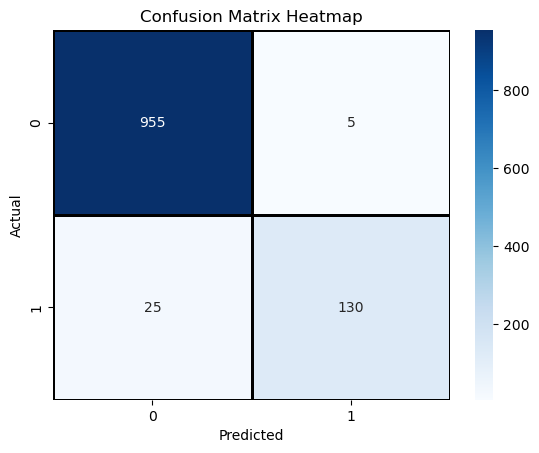

In [61]:
preprocess=ColumnTransformer(
    transformers=[
        ('tfidf',TfidfVectorizer(stop_words="english", max_features=5000),'message')
])
pipe=Pipeline([
    ('step',preprocess),
    ('model',SVC(kernel="rbf"))
])
x=df[['message']]
y=df['type']


x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=43)
# print(x_train,x_test,y_train,y_test)
pipe.fit(x_train,y_train)
pred=pipe.predict(x_test)



print('Accuracy : ',np.round(accuracy_score(y_test,pred)*100,2),'%')
mat = confusion_matrix(y_test,pred)
print(mat)
sns.heatmap(mat,annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='black')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()



In [62]:
scores=cross_val_score(pipe,x,y,cv=10)
print('Score :',scores.mean()*100)
print(scores * 100)

Score : 98.00782481676673
[99.10394265 97.31182796 97.66606822 98.56373429 97.66606822 98.02513465
 97.84560144 97.12746858 98.20466786 98.56373429]


In [63]:
messages = [
"Congratulations! You won a free iPhone! Click the link to claim now 👉 https://win-prize-free.com",
"Your ATM card has been blocked. Call 9898XXXXXX immediately to unlock.",
"Get ₹10,00,000 loan approved instantly! No documents required. Apply here 👉 http://fastloan-now.com",
"You are selected for a job at Amazon! Pay ₹1500 registration fee to confirm your position.",
"Final warning! Your account will be suspended. Verify your password now at http://secure-check.com",
"Free recharge ₹500 on your number! Only for today. Click 👉 http://free-recharge.in",
"You have won a lottery of ₹25,00,000. Contact us to claim your prize.",
"Hot singles are waiting for you. Click to chat instantly 🔞 http://adultconnect.com",
"Dear customer, get free health insurance on your bank account. Pay ₹499 now to activate plan.",
"Your Paytm KYC expired. Complete verification or account will be blocked. Click: http://fake-kyc.com"
]


result=pipe.predict(pd.DataFrame({
    'message':messages
}))
print(result)

[1 0 1 0 1 0 1 1 0 0]


In [67]:
import joblib
joblib.dump(pipe,'spam_message_detect.pkl')

['spam_message_detect.pkl']

In [68]:
message=['Congratulations! You won a free iPhone, click the link to claim now!']

pipe=joblib.load('spam_message_detect.pkl')
result=pipe.predict(pd.DataFrame({
    'message':message
}))[0]
if result==0:
    print('Not Spam Message')
else:
    print('SPAM Message')


SPAM Message
